# 0. AMEX Default Prediction

Key points:

1. The data is anonymized and has been artificially noised. Start with the [parquet data by Raddar](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). 
2. The classes are slightly imbalanced, 3:1. A StratifiedKFold for cross-validation is recommended. However, we don't need to apply class weighted version of models for the signal to noise ratio under 3:1 is acceptable. Also, since the last statement date is the same for all customers, we cannot use TimeSeriesSplit. Use ROC-AUC for evaluation. 
3. Some missing values are systematic, and related to the statement date or the target. We can learn more in depth about it from [Raddar's notebook0(https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition). 
4. D_39 is actually an imperative feature, days_overdue, which is essentially equivalent to the target. Delete it if you don't wanna leak the target. Details are [here](https://www.kaggle.com/code/raddar/deanonymized-days-overdue-feat-amex).
5. There are a few other redundant features according to [this](https://www.kaggle.com/competitions/amex-default-prediction/discussion/338569) and [that](https://www.kaggle.com/code/raddar/redundant-features-amex/notebook).
6. The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). We need to accommodate this variable history length in our model.  
7. Given the innate temporal structure of the data, we should consider doing feature engineering of aggregating over each customer like the following:
    - rolling averages, std, min, max for the numeric features
    - rolling counts and nuniques for the categorical features
    - First occurrence
    - Last occurrence
    - Last_diff_First: the change since we first see the customer to the last time we see the customer
    - Last/First: the fractional difference from the first to the last occurrence


# 1. Module Management and Data Import

In [1]:
# data manipulation
import os
import pandas as pd
import numpy as np
import scipy as sp
# syntax encoding
import datetime
import pickle, gc
pd.options.mode.copy_on_write = True # computation
from joblib import Parallel, delayed  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
from tqdm import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations
import logging   # a standard library module that provides flexible logging for Python
import warnings   # a standard library module that provides flexible logging for Python
import optuna   # an automatic hyperparameter optimization software framework, particularly designed for machine learning
from sklearn.base import clone

In [2]:
# modeling
import shap
from sklearn import datasets, metrics, model_selection, pipeline, preprocessing # datasets: toy datasets, metrics: evaluation metrics, model_selection: model selection, pipeline: pipeline, preprocessing: data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, cross_val_predict
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, early_stopping

In [21]:
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import july
from catboost.utils import get_roc_curve

In [4]:
# Aesthetics
import gc
import warnings
sns.set_style("ticks")
sns.color_palette("husl", 8)
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10
pd.options.display.max_columns = 25
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.2f}'.format
!python --version

Python 3.9.19


## 1.2 The data import
The dataset of this competition has a considerable size. If you read the original csv files, the data barely fits into memory. Thus, we choose to work with a dataset that has reduced data precision.

Meanwhile, as it is discussed in [here by @RADDAR](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514), all float type columns have a uniform noise of Unif[0, 0.01] added to them as the artificial noise by AMEX as a safety measure to further de-anonymize them. The details are like this. The original 190 features have 1 'customer_ID', 1 'S_2' in the datetime type, 95 in the np.int8/np.int16 types, 93 in the np.float32 types. Most float columns with [0, 0.01] and [1, 1.01] have these values rounded up at 0 and 1 respectively. This was done to ensure no data loss, as not all features could be rounded up safe. As a result, the data gets shrinked in size after the noise removel as some previous float data become integers in {0, 1}.  

Based on the above two points, we decide to use the data from [@RADDAR](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). In this Parquet file, the floating point precision has been reduced from 64 bit to 32 bit, then a removal of the artificially added noise further converted some float columns to integers. 

- There are 5.5 million rows for train and 11 million rows of test data. The 'customer_ID' has no duplicates. Both of them have 190 features. The train data takes **2.72** GBytes of RAM. The test data is **twice the size** of the train data.
- The train statement dates range from 2017-03-01 to 2018-03-31.
- The test statement dates range from 2018-04-01 to 2019-10-31.
- The y_train or the target label for all customers is null free.

**Insight**:

    - Given the sheer size of datasets, memory efficiency and copy parsimony is imperative. 

    - Although the entire train data needs to be feed to the ML algorithms, we can make the predictions in batch, meaning batch processing on the test.

    - We don't have to load the test until the models have been trained and tuned. 

    - The customer_ID is in hex coding. (Optional) Remove the first 16 byts and convert the rest to decimal integers.
    
    - (To do) Using Cudf to speed up pandas

In [5]:
y_train = pd.read_csv('data/train_labels.csv')

df_train = pd.read_parquet('data/train.parquet')

df_train['S_2'] = pd.to_datetime(df_train['S_2'])

with pd.option_context("display.min_rows", 4):
    display(df_train)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.94,0,0.01,1.01,0.01,0.12,0.00,0.00,NaN,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.94,0,0.00,1.00,0.01,0.13,0.00,0.00,NaN,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.97,15,0.01,1.00,0.01,0.10,0.00,0.01,NaN,0.01,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.98,0,0.00,0.99,0.00,0.12,0.00,0.01,NaN,0.01,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0


In [6]:
# merge the y_train and df_train as train for EDA purpose
train = df_train.merge(y_train, left_on='customer_ID', right_on='customer_ID')

In [7]:
X_test = pd.read_parquet('data/test.parquet')

X_test['S_2'] = pd.to_datetime(X_test['S_2'])

with pd.option_context("display.min_rows", 4):
    display(X_test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.63,0,0.01,0.81,0.00,0.17,0.00,0.00,0.11,NaN,...,NaN,-1,-1,-1,-1,-1,0,NaN,NaN,-1,0.01,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.59,0,0.01,0.81,0.00,0.24,0.00,0.01,0.12,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.46,0,0.01,0.82,0.00,NaN,0.00,0.01,0.11,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.45,0,0.00,0.81,0.00,NaN,0.00,0.00,0.11,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0


In [8]:
print(f'Train data memory usage: {df_train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {X_test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.72147402 GBytes
Test data memory usage:  5.602334794 GBytes


In [9]:
print(f'The train statement dates range from {df_train.S_2.min()} to {df_train.S_2.max()}.')
print(f'The test statement dates range from {X_test.S_2.min()} to {X_test.S_2.max()}')

The train statement dates range from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.
The test statement dates range from 2018-04-01 00:00:00 to 2019-10-31 00:00:00


# 2. EDA
Columns in the dataset are divided by the organisers in the following groups:
- D_*: Delinquency variables
- S_*: Spend variables
- P_*: Payment variables
- B_*: Balance variables
- R_*: Risk variables
Following features are categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

S_2: contains a timestamp

## 2.1 The target label

In the train, we have 458,913 unique customer_IDs, among which 340,000 (74.1 %) have a label of 0 (never defaulted) and 119,000 (25.9 %) have a label of 1 (defaulted).
In addition, we know that the good customers have been sub-sampled by a factor of 20; this means that in reality there are 6.8 million good customers. Hence, in the original population, 98.3% of the customers are 0; 1.7% are 1.
Furthermore, we verify that the proportion of the target label is roughly consistent across each day in the time period of the train.
Finally, **the label is for the last statement for each customer ONLY, not cumulative. It actually signals whether the customer pay due amount in 120 days after his/her latest statement.**

**Insight**:

    - The classes are 3:1, hence it is not necessary to do stratified split or adjust using class weights.  
    
    - Due to the imbalance, in addition to the competition specific metric, AUC of the ROC and f1-score could be used as auxillary metrics.

In [10]:
label_stats = pd.DataFrame({'Count': y_train.target.value_counts(),
              '%': y_train.target.value_counts() / len(y_train)})
label_stats['Count in population'] =  label_stats['Count'] * np.array([20, 1])
label_stats['% in population'] = label_stats['Count in population'] / label_stats['Count in population'].sum()
label_stats

,Count,%,Count in population,% in population
target,,,,
0,340085,0.74,6801700,0.98
1,118828,0.26,118828,0.02


## 2.2  The time presence of customers

We'd like to know how many rows (credit card statements) each customer has and their distributions. The results is that 80% of the customers have 13 statements; the other 20% of the customers have between 1 and 12 statements.

DO this part's visulization by https://www.kaggle.com/code/datark1/american-express-eda/notebook!!!!!!!!!

**Insight**:

    - The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). 

    - Some customers have short history than 13 months because of later entry (account opend later than March 2017), whereas some customers' short history is 

    - Our model needs to able to deal with a variable observed history record lengths (N) per customer. A good way to pull it through is via adding new customer-level historical aggregated features in the later parts. 


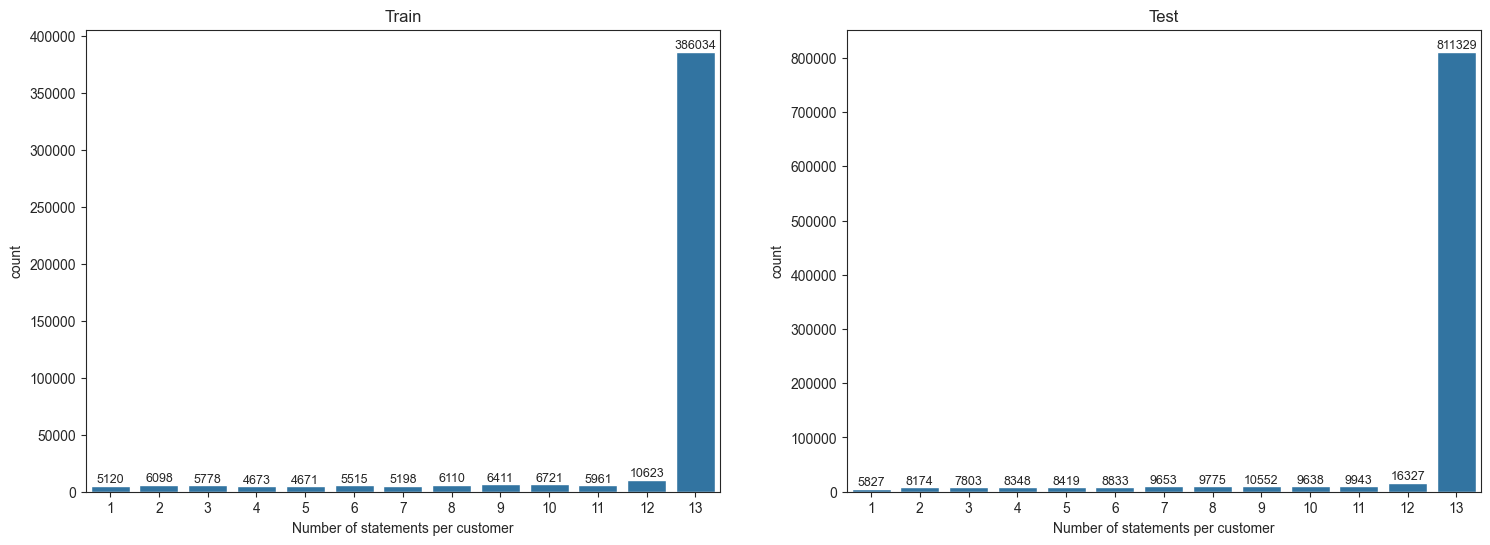

In [11]:
# plot the number of statements per customer as barplots in the train and test data
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(df_train.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[0].set_xlabel('Number of statements per customer')
ax[0].set_title('Train')
sns.barplot(X_test.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[1].set_xlabel('Number of statements per customer')
ax[1].set_title('Test')
plt.show()

Let's find out when these customers got their last statement. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. The first four Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019 and half in October of 2019. As was discussed here, the April 2019 data is used for the public leaderboard and the October 2019 data is used for the private leaderboard.

Although the data are a kind of time series, we cannot cross-validate with a TimeSeriesSplit because all training happens in the same month.

For most customers, the first and last statement is about a year apart. Together with the fact that we typically have 13 statements per customer, this indicates that the customers get one credit card statement every month.

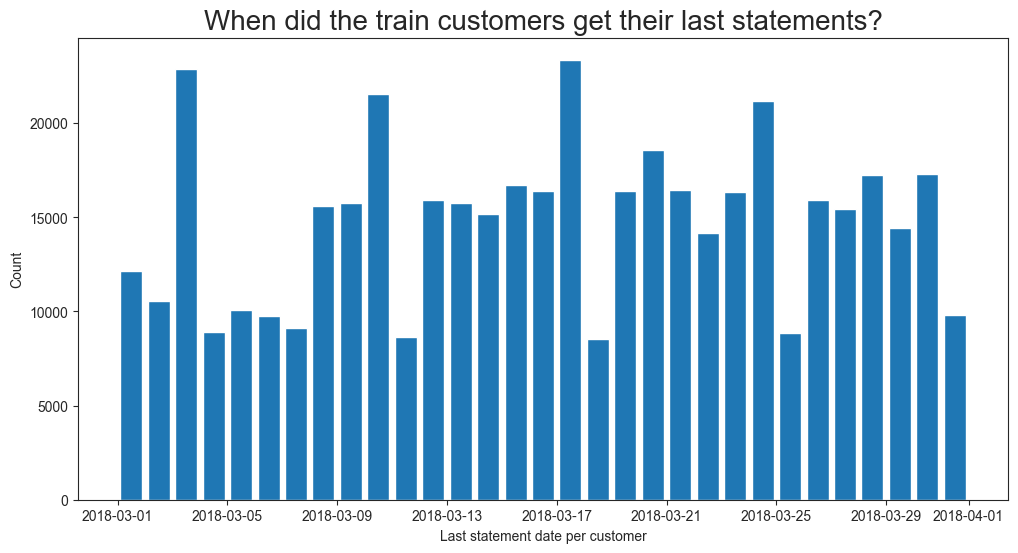

In [12]:
train_last_date = df_train.S_2.groupby(df_train.customer_ID, observed=False).max()
plt.hist(train_last_date, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8)
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del train_last_date

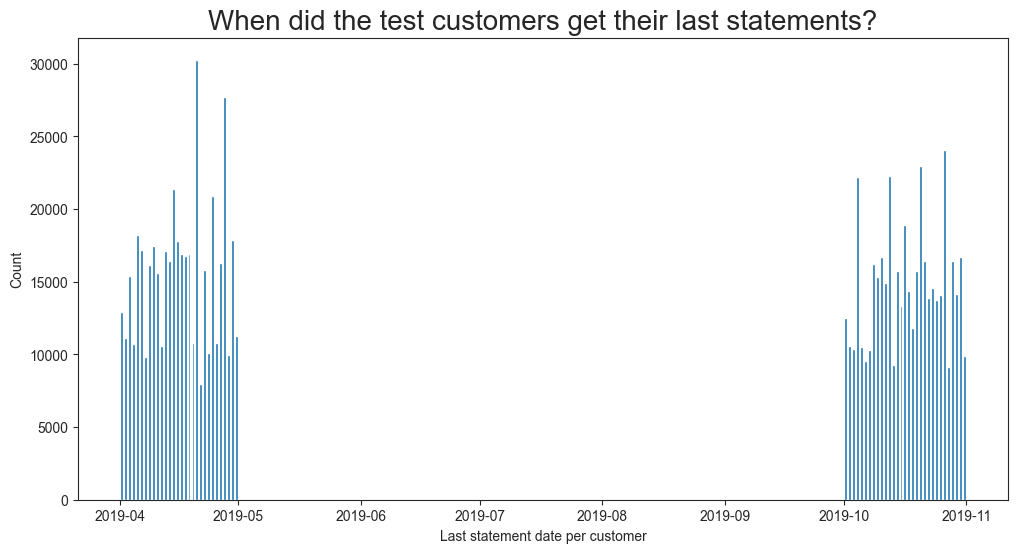

In [13]:
test_last_date = X_test.S_2.groupby(X_test.customer_ID, observed=False).max()
plt.hist(test_last_date, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74)
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del test_last_date

If we color every statement (i.e. row of train or test) according to the dataset it belongs (training, public lb, and private lb), we see that every dataset covers thirteen months. Train and test don't overlap, but public and private lb periods overlap.

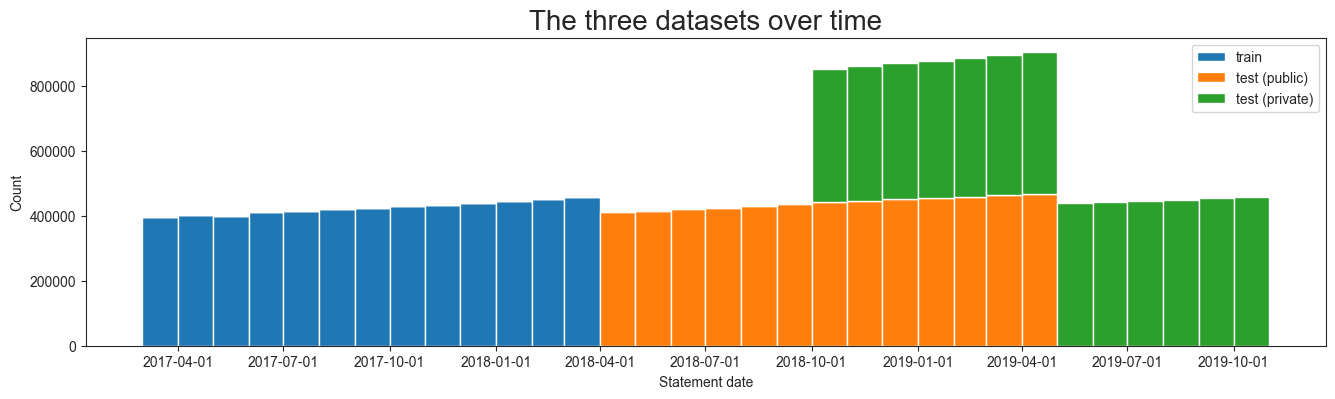

In [14]:
temp = pd.concat([df_train[['customer_ID', 'S_2']], X_test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)

temp['last_month'] = temp.groupby('customer_ID', observed=False).S_2.max().dt.month
last_month = temp['last_month'].values


plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],   # ending 03/18 -> training
          temp.S_2[temp.last_month == 4],   # ending 04/19 -> public lb
          temp.S_2[temp.last_month == 10]], # ending 10/19 -> private lb
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['train', 'test (public)', 'test (private)'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()
del temp

## 2.3 'S_2' datetime stamp related distribution

We observed that Saturday seemed to be the most popular choice among the weekday of statement closing dates across train and test by a huge margin, while Sunday seemed to be the rarest choice. **Nevertheless, consistent higher than average default rates were recorded on Sundays in the train data.**

**Insight**:

    - The statement closing dates for a single customer of every month is NOT set on the same day of the month. E.g. one customer has statement dates on '17-03-11', '17-04-22', '17-05-12', '17-06-10', '17-07-19', '17-08-09', '17-09-06', '17-10-15', '17-11-10', '17-12-19', '18-01-11', '18-02-09', '18-03-12'.

    - Is it worthy to dig up why most customers have their statement closing dates on Saturdays, albeit AMEX has restrictions on how often their customers can request to change the statement closing dates?
    
    - Is it worthy to add a weekday feature during the ensuing feature engineering given we saw the pattern between Sunday and default rate? 

In [15]:
train_S2 = df_train[['customer_ID', 'S_2']].copy()
test_S2 = X_test[['customer_ID', 'S_2']].copy()

train_S2 = pd.merge(train_S2, y_train, on='customer_ID', how='left')


train_S2['N'] = train_S2.groupby('customer_ID', observed=False)['customer_ID'].transform('count')
test_S2['N'] = test_S2.groupby('customer_ID', observed=False)['customer_ID'].transform('count')

test_S2['max_data'] = test_S2.groupby('customer_ID', observed=False)['S_2'].transform('max')
test_S2_1 = test_S2.loc[test_S2['max_data'].apply(lambda t: t.month == 4)]
test_S2_2 = test_S2.loc[test_S2['max_data'].apply(lambda t: t.month == 10)]

tx = train_S2.groupby('S_2')['customer_ID'].count().reset_index(name='count')
ty = train_S2.groupby('S_2')['target'].mean().reset_index(name='target rate')
tw1 = test_S2_1.groupby('S_2')['customer_ID'].count().reset_index(name='count')
tw2 = test_S2_2.groupby('S_2')['customer_ID'].count().reset_index(name='count')

del train_S2, test_S2, test_S2_1, test_S2_2

<Axes: title={'center': 'test (private) count'}>

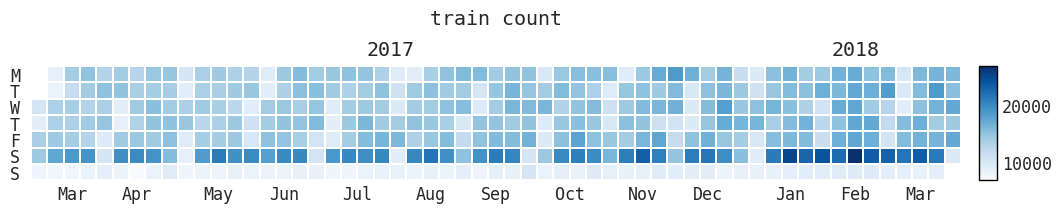

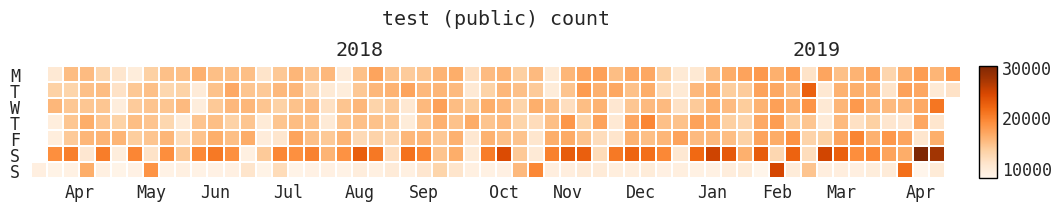

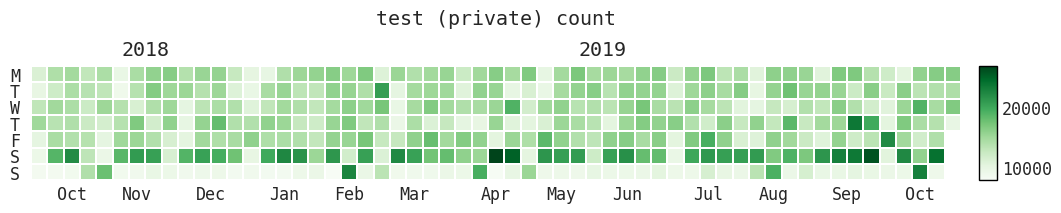

In [16]:
july.heatmap(tx['S_2'], tx['count'], title='train count', cmap="Blues", colorbar=True)
july.heatmap(tw1['S_2'], tw1['count'], title='test (public) count', cmap="Oranges", colorbar=True)
july.heatmap(tw2['S_2'], tw2['count'], title='test (private) count', cmap="Greens", colorbar=True)

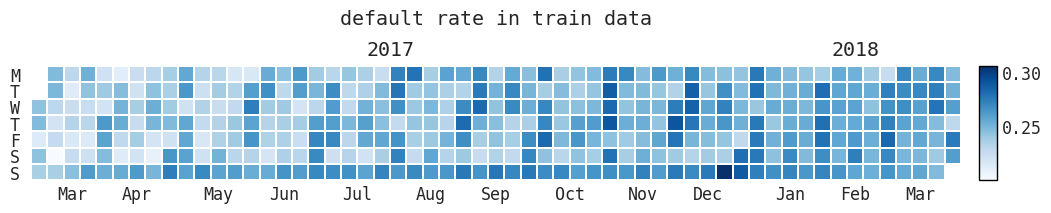

In [17]:
july.heatmap(ty['S_2'], ty['target rate'], title='default rate in train data', cmap="Blues", colorbar=True)
del tx, ty, tw1, tw2

In [18]:
# 'S_2' datetime stamp related distribution
target=pd.DataFrame(data={'Default':train.groupby('S_2')['target'].mean()*100})
target['Paid']=np.abs(train.groupby('S_2')['target'].mean()-1)*100
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='default rate in train data', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

## 2.4 The categorical features

According to the data description, there are 13 categorical features, 11 multilevel ones, 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', and 2 binary ones 'B_31', 'D_87'. We barplot them for fraud and non-fraud. For the ten features which have missing values, the missing values are represented by the rightmost bar of the histogram.


**Insight:**

    - All 13 categorical features are NA-free. 
    
    - All 13 categorical features have below 8 as their cardinalities. Thus, we can use one-hot encoding safely.

In [19]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'B_31', 'D_87']
train[cat_features].isna().sum()

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_66     0
D_68     0
B_31     0
D_87     0
dtype: int64

In [22]:
def plot_cate_by_label_rate(fea, df, rotate=0, order_use=None, hue_label='target', title=None, fontsize=8, ax=None):
    if order_use is None:
        order_use = df[fea].value_counts(ascending=False).index
    
    # Create the countplot
    ax = sns.countplot(x=fea, data=df, order=order_use, hue=hue_label, palette='coolwarm', dodge=True, ax=ax)
    
    # Calculate absolute and relative values
    abs_values = df[fea].value_counts(ascending=False)
    rel_values = df.groupby(fea)[hue_label].mean().loc[df[fea].value_counts(ascending=False).index]
    lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
    
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(rotate)
    
    # Set the title
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f'[{fea}] distribution by {hue_label} rate')
    
    # Add bar labels on top of the bars
    if any(lbls) is not None:
        ax.bar_label(container=ax.containers[1], labels=lbls, fontsize=fontsize, padding=3)
    
    # Set y-axis label
    ax.set_ylabel('Count')
    
    # Set x-axis label
    ax.set_xlabel(fea)
    
    # Handle binary features
    if df[fea].nunique() == 2:
        ax.set_xticks(ticks=[0, 1])
        ax.set_xticklabels(labels=['No', 'Yes'])
    
    # Move legend
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1), labels=['Paid', 'Default'], title=None, fontsize=fontsize)

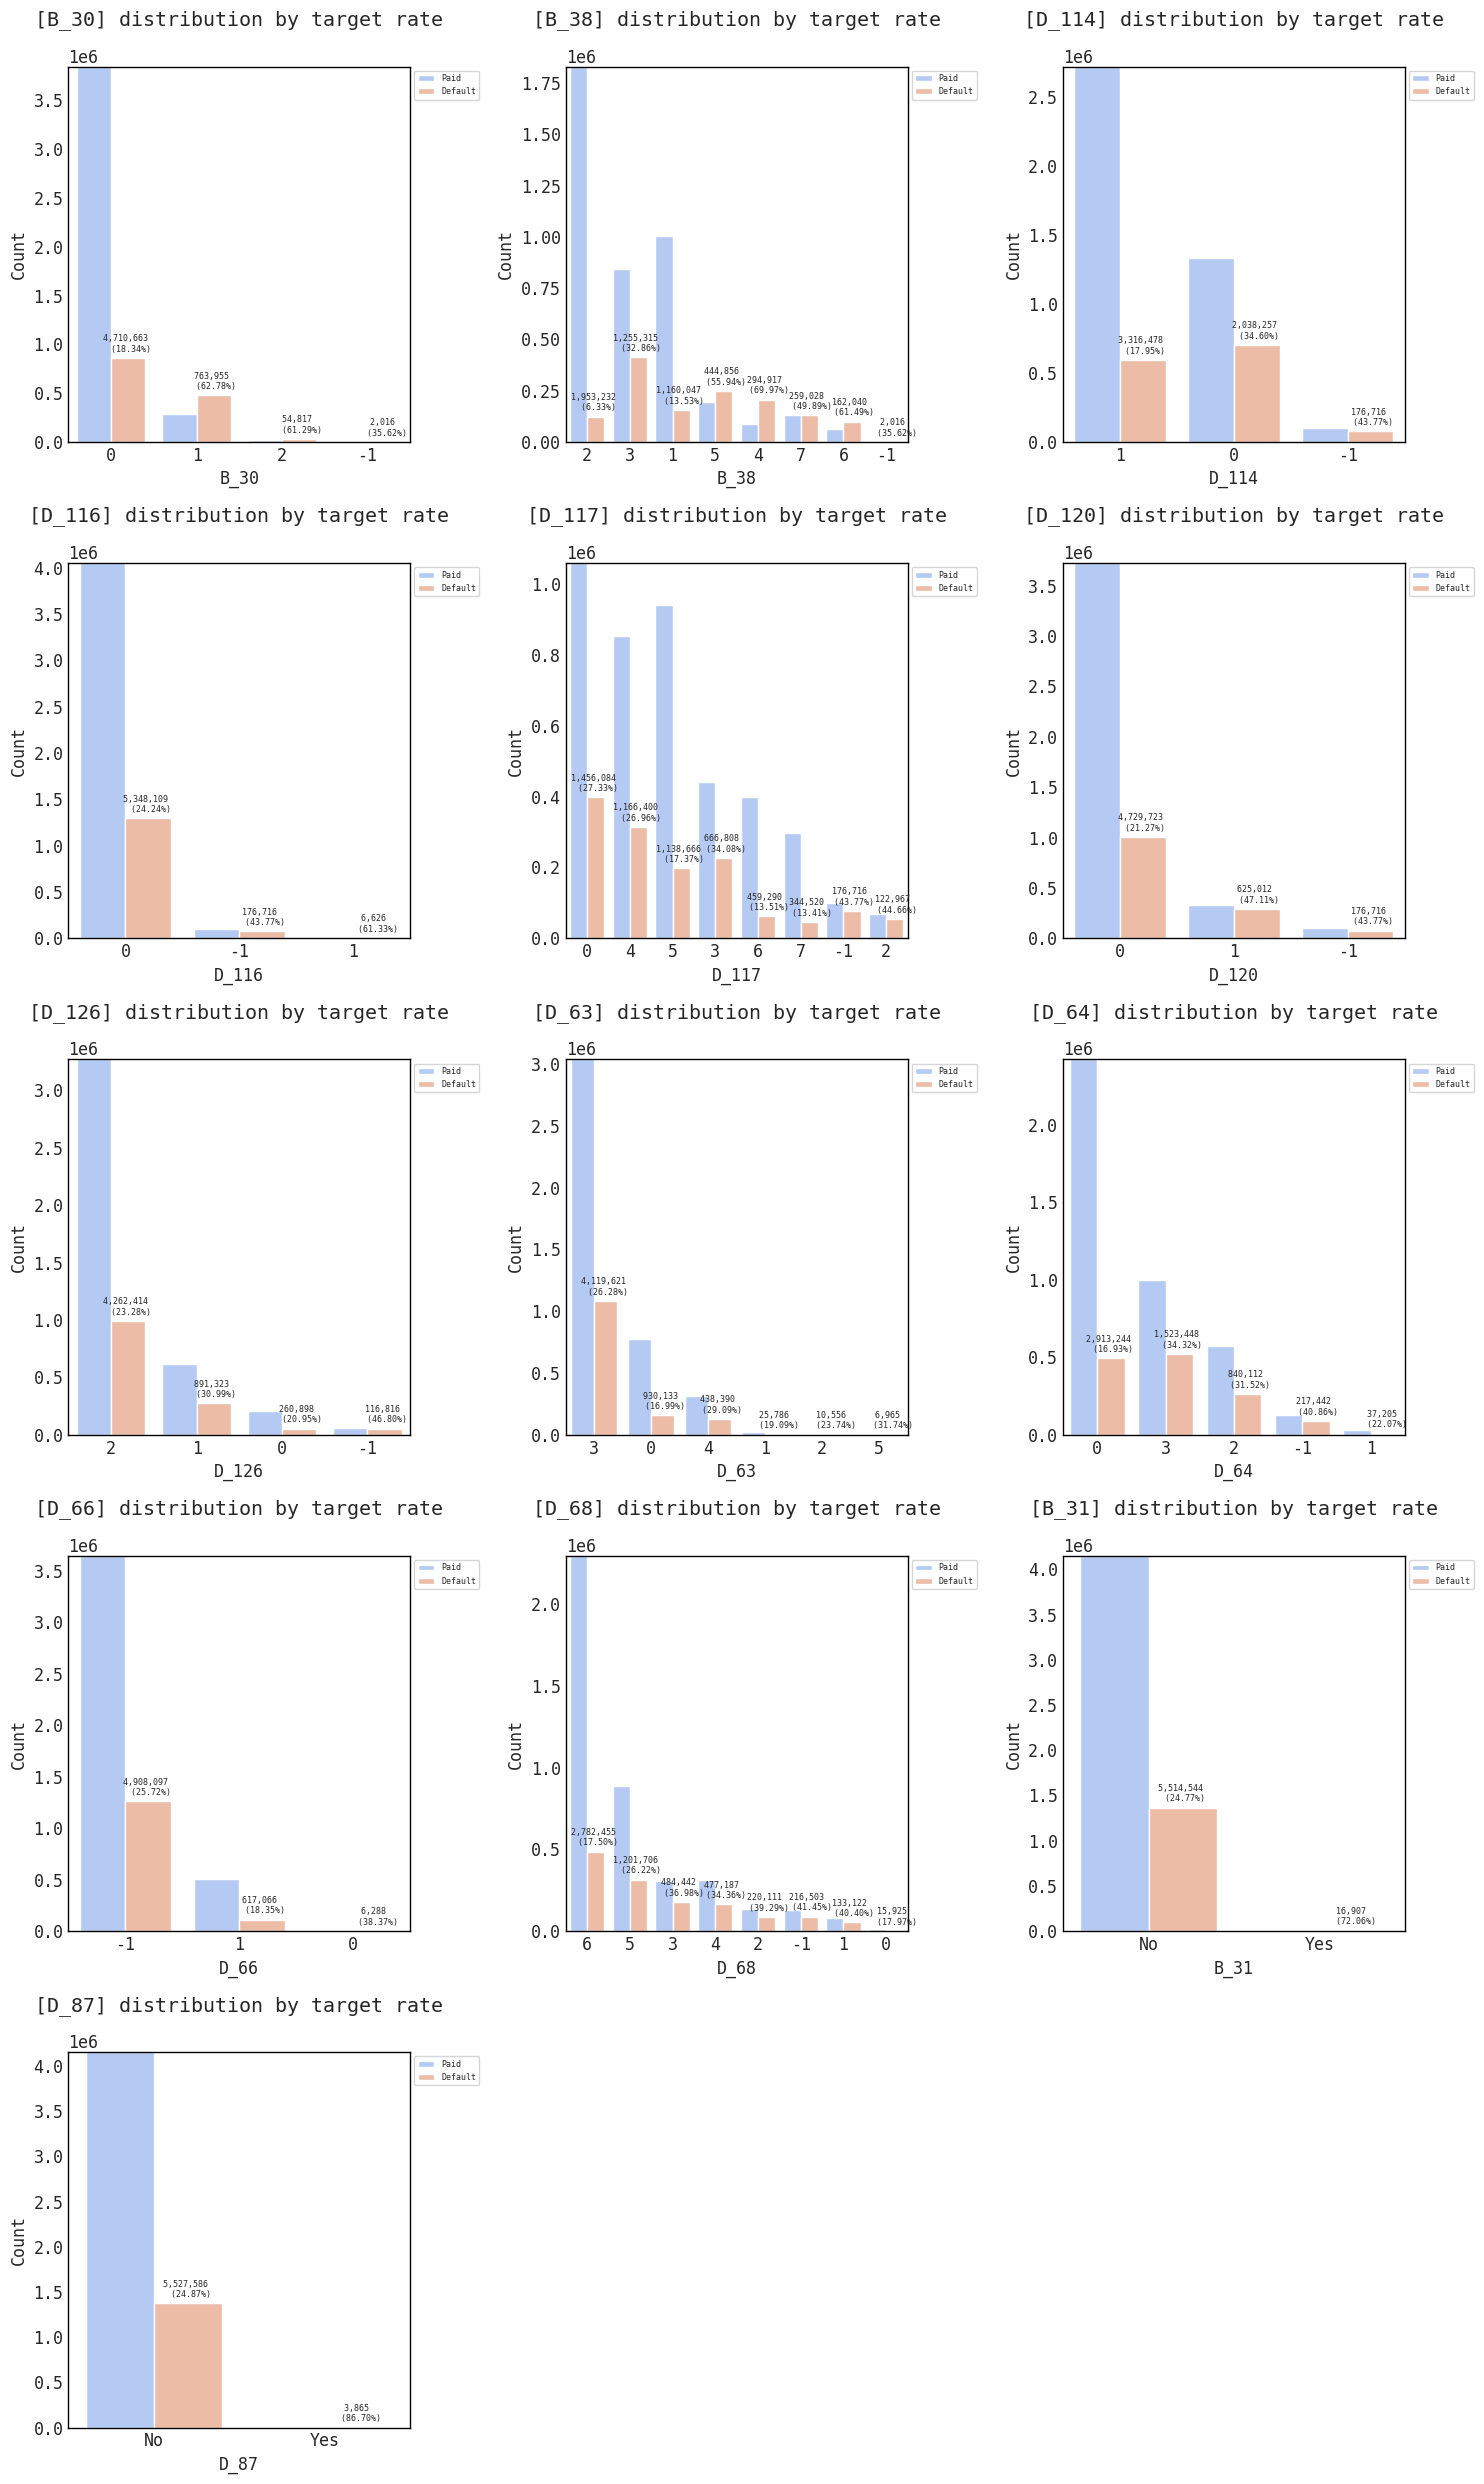

In [24]:
# Determine the number of rows and columns for the subplot grid
num_features = len(cat_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for idx, fea in enumerate(cat_features):
    plot_cate_by_label_rate(fea, train, rotate=0, order_use=None, hue_label='target', title=None, fontsize=6, ax=axes[idx])

# Remove any unused subplots
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


## 2.5 The numerical features

Out of the 175 numerical features, we picked 3 Payment variables and showcase their kernel density estimation plots comparison between the 'Paid' and 'Default'. Similar plots for other numerical features can be generated if needed.

**Insight**:

    - The kernel density for the "Default" and "Paid" groups shows an obvious discrepancy in their 'P_2'. One is highly skewed versus the other one being symmetric. 
    
    - Although the kernel densities in 'P_3' and 'P_4' have similar symmetry, the intergroup scale differences are pretty much noticeable. 

In [25]:
df_train.describe() 

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5531451,5485466.00,5531451.00,5531451.00,5529435.00,5531451.00,4510907.00,5529435.00,5529435.00,791314.00,3873055.00,5531451.00,...,194699.00,5531451.00,5531451.00,5531451.00,5531451.00,5531451.00,5531451.00,5429903.00,944408.00,5531451.00,5490724.00,5531451.00
mean,2017-09-20 21:47:03.013998080,0.66,5.04,0.12,0.62,0.08,0.23,0.06,0.13,0.18,0.15,0.81,...,0.33,-0.96,-0.93,-0.96,-0.95,0.15,0.01,0.16,0.39,0.15,0.05,0.60
min,2017-03-01 00:00:00,-0.46,0.00,-7.59,0.00,0.00,-0.63,0.00,0.00,-0.00,0.00,-1.00,...,-0.01,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,-0.01,-1.00,0.00,-1.00
25%,2017-06-15 00:00:00,0.48,0.00,0.01,0.11,0.00,0.13,0.00,0.01,0.04,0.04,0.00,...,0.11,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00
50%,2017-09-23 00:00:00,0.69,0.00,0.03,0.81,0.01,0.16,0.00,0.01,0.12,0.09,0.00,...,0.22,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.38,0.00,0.01,0.00
75%,2017-12-29 00:00:00,0.86,8.00,0.13,1.00,0.01,0.26,0.00,0.16,0.25,0.18,1.00,...,0.45,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.56,0.00,0.01,0.00
max,2018-03-31 00:00:00,1.01,183.00,1.32,1.01,3.26,5.48,8.99,1.63,4.19,10.11,45.00,...,1.01,1.00,7.00,1.00,6.00,1.00,1.00,1.34,2.23,1.00,1.34,53.00
std,NaN,0.24,9.18,0.21,0.40,0.23,0.19,0.20,0.23,0.23,0.21,1.77,...,0.30,0.19,0.39,0.19,0.26,0.41,0.17,0.35,0.24,0.41,0.18,2.12


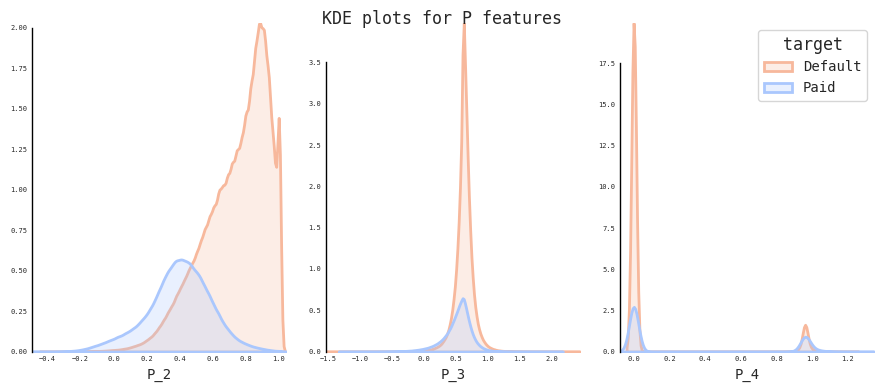

In [26]:
def show_kdeplots(letter, figsize, plot_column_count):   
    cols = [c for c in train.columns if (c.startswith((letter,'t'))) & (c not in cat_features)]
    df_tmp = train[cols]
    plt_cols = plot_column_count
    plt_rows = int(len(cols)/plt_cols)

    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        if i<len(cols)-1:
            sns.kdeplot(x=cols[i], hue='target', hue_order=[1,0], label=['Default','Paid'], data=df_tmp, 
                        fill=True, linewidth=2, legend=False, ax=ax, palette='coolwarm')
        ax.tick_params(left=False, bottom=False, labelsize=5)
        ax.xaxis.get_label().set_fontsize(10)
        ax.set_ylabel('')

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.suptitle(f'KDE plots for {letter} features', fontsize=12)
    plt.legend(title='target', loc='upper right', labels=['Default','Paid'], fontsize=10)
    plt.show()

show_kdeplots('P', (9, 5), 3)

# 3. Preprocessing

## 3.1 Standardization and Outliers

We standardized all of the numerical features for the sake of computation easiness. Outlier detection is omitted for now because they have almost no impact on tree-based models. 

**Insight**:

    - Given the bulk of our training models are tree-based, which are famous for its insensitivity to outliers, we team them up the StandardScalar. However, we can always switch to the MinMaxScalar if the StandardScalar did not render expected performance.  
    
    - Similarly, we always have the option to throw in outliers handling process if the outcome falls under of our expectation. 
    

In [27]:
# select the numerical features
num_features = [c for c in df_train.columns if (c not in ['customer_ID', 'S_2']) and (c not in cat_features)]

# use StandardScaler to scale all of the numerical features
scaler = preprocessing.StandardScaler()
df_train[num_features] = scaler.fit_transform(df_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [28]:
del train

## 3.2 Missing values

The dataset is rich of NA records. Especially it is very likely that we have both systemically missing NA and missing at random NA according to this [discussion](https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition), which suggests feature-wise NA is ought to be treated discriminately when performing the the imputation and feature engineering.  

Some facts:
- 67 out of 189 features have missing values, and they are all numeric features. All categorical features are NA-free.
- Through features R_26 and R_27, the missing pattern of the same feature can vary slightly between the train and test time periods.
- 2 clusters of features with the same missing pattern are found, and we impute each group collectively. 


**Insight:**

    - 17 features' missing rates exceed 50%. We will drop them for model simplicity.

    - The missing pattern of some features varies slightly from train period (2017-2018) to test period (2018-2019). 

    - The missing values are not missing at random. There is a cluster of 6 numeric features that share the same missing pattern, all NAs only occur on the first statement closing dates of selected customers. We assume that those are consequences of the those features, like the lag features, are not well defined for the first statement cycle. Hence, we impute these NAs by 0. 
    
    - There is another cluster of 5 numeric features that share the same missing pattern, but only half of the NAs occur on the first statement closing dates, while the other half are randomly located. Like before, we impute the half NAs inside the first statement closing dates by 0, whereas leaving the rest to be imputed separately.   
    - For the rest of the NAs, we embed Random Forest regressor as the estimator inside the iterative imputer.  

In [29]:
# show the percentage of missing values in the train data
missing = df_train.isnull().mean().sort_values(ascending=False).rename('missing %')
missing = missing[missing > 0]*100

# find the features with more than 50% missing values
fea_100_50_missing = missing[missing >= 50].index.to_list()
fea_100_50_missing

['D_88',
 'D_110',
 'B_39',
 'D_73',
 'B_42',
 'D_134',
 'B_29',
 'D_132',
 'D_76',
 'D_42',
 'D_142',
 'D_53',
 'D_50',
 'B_17',
 'D_105',
 'D_56',
 'S_9']

In [31]:
# drop the features in fea_100_50_missing from the train and test data
df_train.drop(columns=fea_100_50_missing, inplace=True)
X_test.drop(columns=fea_100_50_missing, inplace=True)

Now we'll look at the distribution of missing values over time. B_29 is most interesting. Given the each of the three datasets has almost half a million customers, we see that until May of 2019 fewer than a tenth of the customers have a value for B_29. The other nine tenths are missing. Starting in June of 2019, we have B_29 data for almost every customer.

**Insight:** 
    - The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle.
    - The distribution of the missing B_29 differs between train and test datasets. Whereas in the training and public leaderboard data >90 % are missing, during the last five months of private leaderboard, we have B_29 data for almost every customer. If we use this feature, we should be prepared for surprises in the private leaderboard.

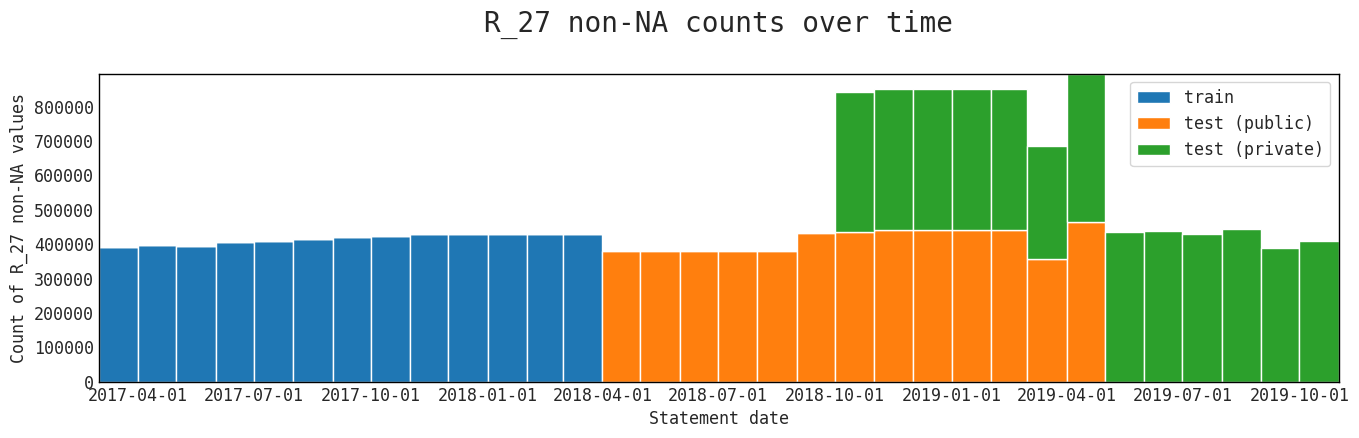

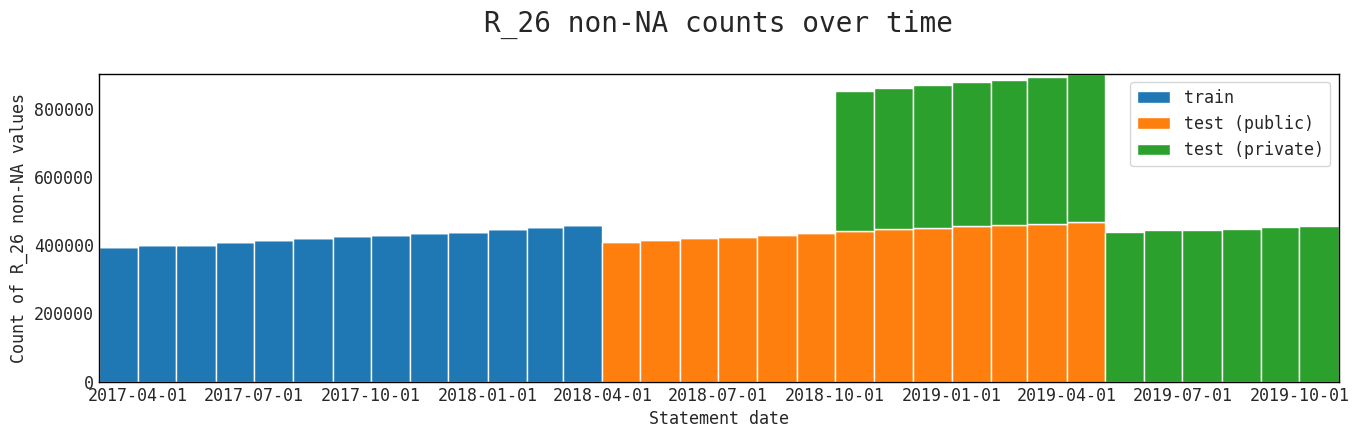

In [32]:
for f in ['R_27','R_26']:# , 'D_77', 'S_27', 'D_108', 'D_111']:
    temp = pd.concat([df_train[[f, 'S_2']], X_test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['train', 'test (public)', 'test (private)'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-NA values')
    plt.title(f'{f} non-NA counts over time', fontsize=20)
    plt.legend()
    plt.show()
del temp

The idea is to identify feature clusters having the same NA values for each row - that is what I will be focusing in this notebook onwards. Let's explore clusters having more than 4 features.

In [33]:
cols = sorted(df_train.columns[2:].tolist())
nas = df_train[cols].isna().sum(axis=0).reset_index(name='NA_count')
nas['group_count'] = nas.loc[nas.NA_count>0].groupby('NA_count').transform('count')
clusters = nas.loc[nas.group_count>4].sort_values(['NA_count','index']).groupby('NA_count')['index'].apply(list).values
clusters

array([list(['B_2', 'B_26', 'B_27', 'B_3', 'D_41', 'D_54']),
       list(['D_104', 'D_128', 'D_130', 'D_131', 'D_141'])], dtype=object)

### 3.2.2 Two clusters of NA containing features
There are 2 large clusters having many overlapping NA rows! Let's analyse each cluster!

In [34]:
cluster0_customers = set(df_train.loc[pd.isnull(df_train[clusters[0][0]]),'customer_ID'])
cluster1_customers = set(df_train.loc[pd.isnull(df_train[clusters[1][0]]),'customer_ID'])

#### 3.2.2.1 cluster ONE
Let's just simply look at how the customer profile looks for this feature cluster:

In [35]:
df_train.loc[df_train.customer_ID.isin(cluster0_customers),['customer_ID','S_2']+clusters[0]].head(30)

,customer_ID,S_2,B_2,B_26,B_27,B_3,D_41,D_54
12883,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2017-11-06,NaN,NaN,NaN,NaN,NaN,NaN
12884,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2017-12-31,0.49,-0.03,1.18,-0.56,-0.27,0.14
12885,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-01-05,-1.36,-0.03,0.92,-0.42,-0.27,0.14
12886,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-02-15,-1.55,-0.03,-0.70,0.29,-0.27,0.14
12887,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-03-03,-1.51,-0.03,0.74,0.63,-0.27,0.14
15183,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-03-09,NaN,NaN,NaN,NaN,NaN,NaN
15184,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-04-29,0.48,-0.03,0.87,-0.52,-0.27,0.14
15185,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-05-08,-1.30,-0.03,1.27,-0.45,-0.27,0.14
15186,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-06-07,-1.28,-0.03,1.16,-0.41,-0.27,0.14
15187,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-07-08,-1.31,-0.03,1.62,-0.37,-0.27,0.14


In [36]:
# For the features in this cluster, how many customers have NA only show up in their first rows?
print('NA counts, only in first rows of the customer')
print(df_train.loc[df_train.customer_ID.isin(cluster0_customers)].groupby('customer_ID', observed=False)[clusters[0]].head(1).isna().sum(axis=0))

# For the features in this cluster, how many customers have NA only show up in all rows?
print('NA counts, in all rows of the customer')
print(df_train[clusters[0]].isna().sum(axis=0))

NA counts, only in first rows of the customer
B_2     2016
B_26    2016
B_27    2016
B_3     2016
D_41    2016
D_54    2016
dtype: int64
NA counts, in all rows of the customer
B_2     2016
B_26    2016
B_27    2016
B_3     2016
D_41    2016
D_54    2016
dtype: int64


Were you able to notice the pattern? What if I told you that NA appears only on the first observation for each customer! So for this feature cluster NA represents fresh credit card accounts with probably zero balance!

Q: How could I use this information?
We know that the dataset has varying number of available observations for each customer (N=1,...,13). It is only naturally obvious that 'last' type features are the strongest ones during model building. For N=1 observations things tend to get interesting, for those NAs devastate the 'last' type features, which may be quite a headache for non-GBDT models in particular. 
**Hence, it is now safe to impute the NAs amongs all features within this cluster to zeros. ** 

In [37]:
# for features in ['B_2', 'B_26', 'B_27', 'B_3', 'D_41', 'D_54'], fill the missing values of the first occurrence of each customer with 0
df_train.loc[df_train.customer_ID.isin(cluster0_customers), ['B_2', 'B_26', 'B_27', 'B_3', 'D_41', 'D_54']] = df_train.loc[df_train.customer_ID.isin(cluster0_customers), ['B_2', 'B_26', 'B_27', 'B_3', 'D_41', 'D_54']].fillna(0)

#### 3.2.2.2 cluster TWO

Again, simply look at what the data has to show:

    - This appears similar to cluster ONE. However, only half of the NA are in the first row!
    - For the first-row NAs, we will make the same zero imputation on them. 
    - For the other half non-first-row NAs, they seem to occur randomly. We will impute them along with other features during later phases. 

In [38]:
df_train.loc[df_train.customer_ID.isin(cluster1_customers),['customer_ID','S_2']+clusters[1]].head(30)

,customer_ID,S_2,D_104,D_128,D_130,D_131,D_141
133,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-03-25,1.05,0.86,-0.49,-0.33,-0.46
134,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-04-14,1.06,0.85,-0.49,-0.33,-0.46
135,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-05-13,NaN,NaN,NaN,NaN,NaN
136,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-06-12,1.07,0.85,-0.49,-0.33,-0.46
137,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-07-01,1.07,0.85,-0.49,-0.33,-0.46
138,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-08-18,1.07,0.84,-0.49,-0.33,-0.46
139,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-09-09,1.06,0.84,-0.49,-0.33,-0.46
140,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-10-02,1.07,0.85,-0.49,-0.33,-0.46
141,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-11-13,1.07,0.84,-0.49,-0.33,-0.46
142,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-12-21,1.07,0.85,-0.49,-0.33,-0.46


In [39]:
# For the features in this cluster1, how many customers have NA only show up in their first rows?
print('NA counts, only in first rows of the customer')
print(df_train.loc[df_train.customer_ID.isin(cluster1_customers)].groupby('customer_ID', observed=False)[clusters[1]].head(1).isna().sum(axis=0))

# For the features in this cluster1, how many customers have NA only show up in all rows?
print('NA counts, in all rows of the customer')
print(df_train[clusters[1]].isna().sum(axis=0))

NA counts, only in first rows of the customer
D_104    49166
D_128    49166
D_130    49166
D_131    49166
D_141    49166
dtype: int64
NA counts, in all rows of the customer
D_104    101548
D_128    101548
D_130    101548
D_131    101548
D_141    101548
dtype: int64


In [40]:
# find the index of the first occurrence of each customer in cluster1 
cluster1_1st_idx = df_train.loc[df_train.customer_ID.isin(cluster1_customers)].groupby('customer_ID', observed=False)[clusters[1]].head(1).index

# fill the missing values of the first occurrence of each customer in cluster1 with 0
df_train.loc[cluster1_1st_idx, clusters[1]] = df_train.loc[cluster1_1st_idx, clusters[1]].fillna(0)

### 3.2.3 Imputation via Random Forest

Given the temporal structure and correlations among multiple features of data, we decide to use iterative imputer that adopting a round-robin fashion instead of the simple imputer which is best for column by column action. Furthermore, due to the fact that the missing values only take place in numerical columns by this point, we will embed Random Forest regressor as the estimator inside the iterative imputer.    

In [ ]:
# Time Warning, 81 minutes!
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the imputer with Random Forest as the estimator
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=50, max_depth=4, n_jobs=15),
    max_iter=2,
    random_state=0,
    skip_complete=True,
    n_nearest_features=7
)

# Function to apply imputation to a partition
def impute_partition(partition):
    partition = partition.astype(np.float32)  # Ensure input is float32
    imputed = imputer.fit_transform(partition)
    return pd.DataFrame(imputed, columns=partition.columns, index=partition.index).astype(np.float32)  # Ensure output is float32

# Split the DataFrame into chunks for parallel processing
def split_dataframe(df, n_chunks):
    return np.array_split(df, n_chunks)

# Number of chunks for parallel processing
n_chunks = 30
chunks = split_dataframe(df_train.drop(columns=['customer_ID', 'S_2'], inplace=False).astype(np.float32), n_chunks)  # Ensure input is float32

# Apply the imputer in parallel with a progress bar
logging.info("Starting parallel imputation with progress bar...")
imputed_chunks = Parallel(n_jobs=15)(
    delayed(impute_partition)(chunk) for chunk in tqdm(chunks, desc="Imputing chunks")
)

# Concatenate the imputed chunks back into a single DataFrame
df_train_imputed = pd.concat(imputed_chunks)

logging.info("Imputation completed.")


In [49]:
missing = df_train.isnull().mean().sort_values(ascending=False).rename('missing %')
missing = missing[missing > 0]*100

# Merge the imputed numeric columns back to the original DataFrame
df_train[missing.index] = df_train_imputed[missing.index].astype(np.float32)  # Ensure output is float32

In [ ]:
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# do the same imputation for the test data
# Split the DataFrame into chunks for parallel processing
n_chunks = 60
chunks = split_dataframe(X_test.drop(columns=['customer_ID', 'S_2'], inplace=False).astype(np.float32), n_chunks)  # Ensure input is float32

# Apply the imputer in parallel with a progress bar
logging.info("Starting parallel imputation with progress bar...")
imputed_chunks = Parallel(n_jobs=15)(
    delayed(impute_partition)(chunk) for chunk in tqdm(chunks, desc="Imputing chunks")
)

# Concatenate the imputed chunks back into a single DataFrame
X_test_imputed = pd.concat(imputed_chunks)

logging.info("Imputation completed.")

missing_test = X_test.isnull().mean().sort_values(ascending=False).rename('missing %')
missing_test = missing_test[missing_test > 0]*100

# Merge the imputed numeric columns back to the original DataFrame
X_test[missing_test.index] = X_test_imputed[missing_test.index].astype(np.float32)  # Ensure output is float32


In [361]:
del df_train_imputed, X_test_imputed, imputer, chunks, imputed_chunks
print(f'{df_train.isna().sum().sum()} missing values in the train data after imputation.')
print(f'{X_test.isna().sum().sum()} missing values in the test data after imputation.')

0

# 4. Feature Engineering

## 4.1 Extract the weekday out of 'S_2' and drop 'S_2' 
We do this because of the observation from the 'S_2' datetime stamp related distribution shows  

In [54]:
# extract the day of week from 'S_2' and drop the 'S_2' column
day_of_week = df_train['S_2'].dt.day_of_week
df_train.drop(columns='S_2', inplace=True)

# Concatenate the new column with the existing DataFrame
df_train = pd.concat([df_train, day_of_week.rename('DofW')], axis=1)

# Add the new column to the list of categorical features
cat_features.append('DofW')

In [ ]:
# do the same for the test data
day_of_week = X_test['S_2'].dt.day_of_week
X_test.drop(columns='S_2', inplace=True)
X_test = pd.concat([X_test, day_of_week.rename('DofW')], axis=1)

## 4.2 Aggregation

For every categorical feature, we use the following feature aggregation on the customer level to replace the original feature:

    - first: first occurring value;

    - last: last occurring value;
    
    - count: count of occurrences;
    
    - nunique: count of unique occurrences.

For every numeric feature, we use the following feature aggregation on the customer level to replace the original feature:

    - first: first occurring value;
    
    - last: last occurring value;
    
    - min: minimal occurring value;
    
    - max: maximal occurring value;
    
    - mean: mean occurring values;
    
    - std: standard deviation of the occurring values;
    
    - lag_sub: the change since we first see the customer to the last time we see the customer;
    
    - lab_div: the fractional difference from the first to the last occurrence. 

In [55]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# get the numerical features
num_features = [c for c in df_train.columns if c not in cat_features and c != 'customer_ID']

# aggregate the numerical features by customer using first, mean, std, min, max, and last
train_num_agg = df_train.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
# Flatten the MultiIndex columns
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
# Reset the index
train_num_agg.reset_index(inplace = True)

In [56]:
# add lag features for the numerical features in train_num_agg

# Collect new columns in a dictionary
new_columns = {}

for col in train_num_agg:
    if 'last' in col and col.replace('last', 'first') in train_num_agg:
        new_columns[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
        new_columns[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns)

# Concatenate the new columns to the original DataFrame
train_num_agg = pd.concat([train_num_agg, new_columns_df], axis=1)

In [57]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# aggregate the categorical features by customer using first, mode, and last
train_cat_agg = df_train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
train_cat_agg.reset_index(inplace = True)

In [58]:
train_num_agg.shape

(458913, 1265)

In [59]:
# merge the numerical and categorical features
train_agg = train_num_agg.merge(train_cat_agg, on='customer_ID', how='inner')
print(f'The shape of the aggregated train data: {train_agg.shape}')
del train_num_agg, train_cat_agg
gc.collect()

# save the aggregated train data to a parquet file
train_agg.to_parquet('data/train_agg.parquet', index=False)

The shape of the aggregated train data: (458913, 1321)


In [60]:
# save the categorical features to a pickle file
with open('data/cat_features.pkl', 'wb') as f:
    pickle.dump(cat_features, f)

In [ ]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# do the same for the test data
# aggregate the numerical features by customer using first, mean, std, min, max, and last
test_num_agg = X_test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
# Flatten the MultiIndex columns
test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
# Reset the index
test_num_agg.reset_index(inplace = True)

In [ ]:
# add lag features for the numerical features in test_num_agg

# Collect new columns in a dictionary
new_columns = {}

for col in test_num_agg:
    if 'last' in col and col.replace('last', 'first') in test_num_agg:
        new_columns[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
        new_columns[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns)

# Concatenate the new columns to the original DataFrame
test_num_agg = pd.concat([test_num_agg, new_columns_df], axis=1)

In [ ]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# do the same for the test data
test_cat_agg = X_test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
test_cat_agg.reset_index(inplace = True)

In [ ]:
test_num_agg.shape

In [ ]:
# merge the numerical and categorical features
test_agg = test_num_agg.merge(test_cat_agg, on='customer_ID', how='inner')
print(f'The shape of the aggregated test data: {test_agg.shape}')
del test_num_agg, test_cat_agg
gc.collect()

# save the aggregated test data to a parquet file
test_agg.to_parquet('data/test_agg.parquet', index=False)

# 5. Modeling

We use the LightGBM as our baseline model and hyperparameter tuning model for all GDBT models, such as CatBoost.

In [5]:
# load the aggregated train data
train_agg = pd.read_parquet('data/train_agg.parquet')
# reset the index as the customer_ID
train_agg.set_index('customer_ID', inplace=True)
# load the target labels
target = pd.read_csv('data/train_labels.csv')
# set the customer_ID as the index
target.set_index('customer_ID', inplace=True)

In [6]:
# load the categorical features
with open('data/cat_features.pkl', 'rb') as f:
    cat_features = pickle.load(f)

In [7]:
train_agg

,P_2_first,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_first,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,B_31_count,B_31_first,B_31_last,B_31_nunique,D_87_count,D_87_first,D_87_last,D_87_nunique,DofW_count,DofW_first,DofW_last,DofW_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,1.15,1.13,0.10,0.87,1.24,1.14,-0.55,-0.52,0.09,-0.55,-0.22,-0.55,...,13,1,1,1,13,-1,-1,1,13,3,1,6
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,1.12,1.00,0.09,0.84,1.12,0.92,0.87,0.23,0.73,-0.55,1.52,0.10,...,13,1,1,1,13,-1,-1,1,13,2,6,5
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.90,0.91,0.12,0.58,1.01,0.92,-0.55,-0.55,0.00,-0.55,-0.55,-0.55,...,13,1,1,1,13,-1,-1,1,13,5,0,6
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.36,-0.23,0.08,-0.36,-0.13,-0.14,0.43,-0.38,0.33,-0.55,0.43,-0.55,...,13,1,1,1,13,-1,-1,1,13,4,3,5
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,1.15,0.96,0.17,0.61,1.16,0.88,-0.55,-0.55,0.00,-0.55,-0.55,-0.55,...,13,1,1,1,13,-1,-1,1,13,3,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.83,0.79,0.17,0.30,0.98,0.77,-0.22,-0.13,0.72,-0.55,1.63,1.09,...,13,1,1,1,13,-1,-1,1,13,0,5,7
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.85,0.83,0.05,0.72,0.87,0.72,-0.55,-0.32,0.46,-0.55,1.19,-0.44,...,13,1,1,1,13,-1,-1,1,13,2,3,6
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.56,0.53,0.06,0.41,0.60,0.59,1.41,0.26,0.68,-0.55,1.41,0.43,...,13,1,1,1,13,-1,-1,1,13,3,2,6


In [8]:
# Split the train_agg and y_train into train (80%) and test sets (20%) stratified by the target
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_agg, target, test_size=0.2, random_state=42, stratify=target['target'])


## 5.1 LightGBM(DART)

In [9]:
SEED = 127
N_FOLD = 3
N_TRIALS = 5

In [120]:
# Set up logging to print messages to the console
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# list of categorical feature names, which are the original cat_features' firsts and lasts
categorical_features = [f'{cf}_first' for cf in cat_features] + [f'{cf}_last' for cf in cat_features]

for c in categorical_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Define the objective function for Optuna optimization of the LightGBM model
def objective(trial):

    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 7, 9),
        'num_leaves': trial.suggest_categorical('num_leaves', [2**i for i in range(7, 9)]),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.5),
        'bagging_freq': trial.suggest_int('bagging_freq', 8, 10),
        'bagging_fraction': 0.5,
        'min_data_in_leaf': 32, 
        'lambda_l2': 2,
        'boosting_type':'dart',
        'categorical_feature': categorical_features,
        'metric': 'AUC',
        'random_seed': SEED, 
        'n_estimators': 500,
        'n_jobs': 15
    }

    model = LGBMClassifier(**param)
    skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=15)
    return scores.mean()

# Set up the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-10-03 15:42:34,686] A new study created in memory with name: no-name-fd57091b-60cb-4075-82aa-d77f24f2d4bb
[I 2024-10-03 15:50:29,499] Trial 0 finished with value: 0.9598648724422582 and parameters: {'learning_rate': 0.14438466711447245, 'max_depth': 10, 'num_leaves': 64, 'colsample_bytree': 0.5914149772023657, 'feature_fraction': 0.33293129172134117, 'bagging_freq': 4}. Best is trial 0 with value: 0.9598648724422582.
[I 2024-10-03 15:55:59,401] Trial 1 finished with value: 0.9599713348139062 and parameters: {'learning_rate': 0.12851693887490923, 'max_depth': 9, 'num_leaves': 64, 'colsample_bytree': 0.7401701009249495, 'feature_fraction': 0.3557966895544099, 'bagging_freq': 8}. Best is trial 1 with value: 0.9599713348139062.
[I 2024-10-03 16:01:55,320] Trial 2 finished with value: 0.9593870199727131 and parameters: {'learning_rate': 0.06230670403836319, 'max_depth': 10, 'num_leaves': 128, 'colsample_bytree': 0.770421948187742, 'feature_fraction': 0.2544226645636238, 'bagging_fre

In [123]:
# Get the best parameters
best_params_lgbm = study.best_params

# Train the final model with the best parameters
model_lgbm = LGBMClassifier(**best_params_lgbm,
                            categorical_feature=categorical_features, eval_metric='AUC', random_seed=SEED,
                            n_estimators=2_000, n_jobs=15)

# Split the training data into training and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)


# Train the model
model_lgbm.fit(X_train_split, y_train_split, eval_set=(X_valid_split, y_valid_split), categorical_feature=categorical_features, eval_metric='AUC',
                eval_names=['validation'], callbacks=[early_stopping(stopping_rounds=100)])

h:\Software\miniforge3\envs\torch\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

h:\Software\miniforge3\envs\torch\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

h:\Software\miniforge3\envs\torch\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

h:\Software\miniforge3\envs\torch\lib\site-packages\lightgbm\basic.py:2034: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

h:

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3557966895544099, colsample_bytree=0.7401701009249495 will be ignored. Current value: feature_fraction=0.3557966895544099
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3557966895544099, colsample_bytree=0.7401701009249495 will be ignored. Current value: feature_fraction=0.3557966895544099
[LightGBM] [Warning] categorical_feature is set=B_30_first,B_38_first,D_114_first,D_116_first,D_117_first,D_120_first,D_126_first,D_63_first,D_64_first,D_66_first,D_68_first,B_31_first,D_87_first,DofW_first,B_30_last,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last,B_31_last,D_87_last,DofW_last, categorical_column=1265,1266,1269,1270,1273,1274,1277,1278,1281,1282,1285,1286,1289,1290,1293,129

h:\Software\miniforge3\envs\torch\lib\site-packages\lightgbm\basic.py:2034: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

h:\Software\miniforge3\envs\torch\lib\site-packages\lightgbm\basic.py:2054: UserWarning:

categorical_feature in param dict is overridden.



[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3557966895544099, colsample_bytree=0.7401701009249495 will be ignored. Current value: feature_fraction=0.3557966895544099
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258934 -> initscore=-1.051516
[LightGBM] [Info] Start training from score -1.051516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	validation's auc: 0.959292	validation's binary_logloss: 0.223708


LGBMClassifier(bagging_freq=8,
               categorical_feature=['B_30_first', 'B_38_first', 'D_114_first',
                                    'D_116_first', 'D_117_first', 'D_120_first',
                                    'D_126_first', 'D_63_first', 'D_64_first',
                                    'D_66_first', 'D_68_first', 'B_31_first',
                                    'D_87_first', 'DofW_first', 'B_30_last',
                                    'B_38_last', 'D_114_last', 'D_116_last',
                                    'D_117_last', 'D_120_last', 'D_126_last',
                                    'D_63_last', 'D_64_last', 'D_66_last',
                                    'D_68_last', 'B_31_last', 'D_87_last',
                                    'DofW_last'],
               colsample_bytree=0.7401701009249495, eval_metric='AUC',
               feature_fraction=0.3557966895544099,
               learning_rate=0.12851693887490923, max_depth=9,
               n_estimators=2000, n_jobs=15, num_leaves=64, random_seed=127)

In [124]:
# get the best iteration number of the LGBM model
best_iter_train_lgbm = model_lgbm.best_iteration_

# get the best AUC score on validation set
best_score_train_lgbm = model_lgbm.best_score_['validation']['auc']

# Make predictions on the test set
y_pred_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

# Calculate the roc_auc score on the test set
roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)

# Add the SHAP values to the test set
explainer_lgbm = shap.TreeExplainer(model_lgbm, feature_perturbation='tree_path_dependent')
shap_values_lgbm = explainer_lgbm.shap_values(X_test)
df_shap_lgbm = pd.DataFrame(shap_values_lgbm, columns=X_test.columns)
fea_imp_lgbm = df_shap_lgbm.abs().mean().sort_values(ascending=False)

# Print the best parameters and score
print(f"The LGBM best parameters are: {best_params_lgbm}")
print(f"The LGBMbest iteration number is: {best_score_train_lgbm}.")
print(f"The LGBM best AUC score on the validation set is: {best_score_train_lgbm:.4f}")
print(f"The LGBM roc_auc score on the test set is: {roc_auc_lgbm:.4f}")

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3557966895544099, colsample_bytree=0.7401701009249495 will be ignored. Current value: feature_fraction=0.3557966895544099
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


h:\Software\miniforge3\envs\torch\lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



The LGBM best parameters are: {'learning_rate': 0.12851693887490923, 'max_depth': 9, 'num_leaves': 64, 'colsample_bytree': 0.7401701009249495, 'feature_fraction': 0.3557966895544099, 'bagging_freq': 8}
The LGBMbest iteration number is: 0.9592916357237831.
The LGBM best AUC score on the validation set is: 0.9593
The LGBM roc_auc score on the test set is: 0.9607


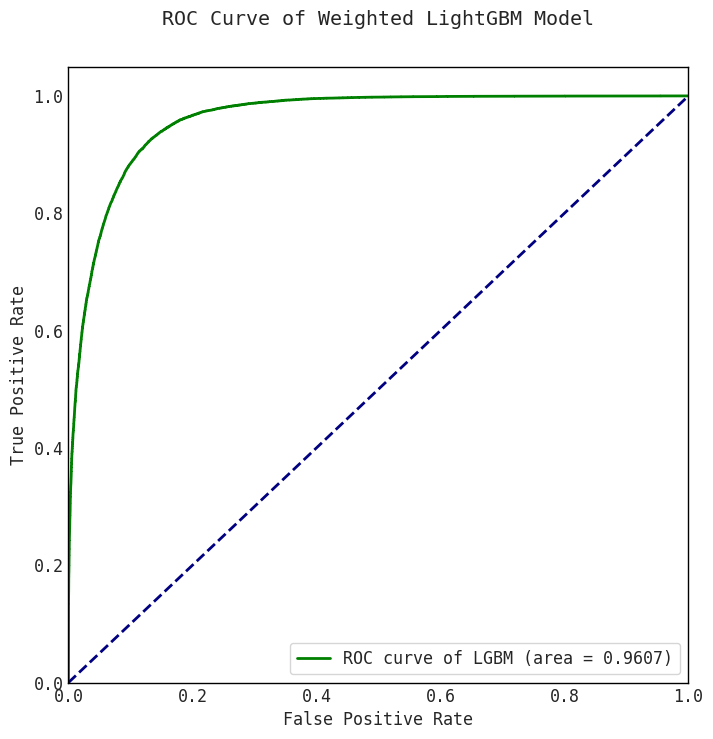

In [126]:
# print the ROC curve
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm)
# plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lgbm, tpr_lgbm, color='green', lw=2, label='ROC curve of LGBM (area = %0.4f)' % roc_auc_lgbm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Weighted LightGBM Model')
plt.legend(loc="lower right")
plt.show()

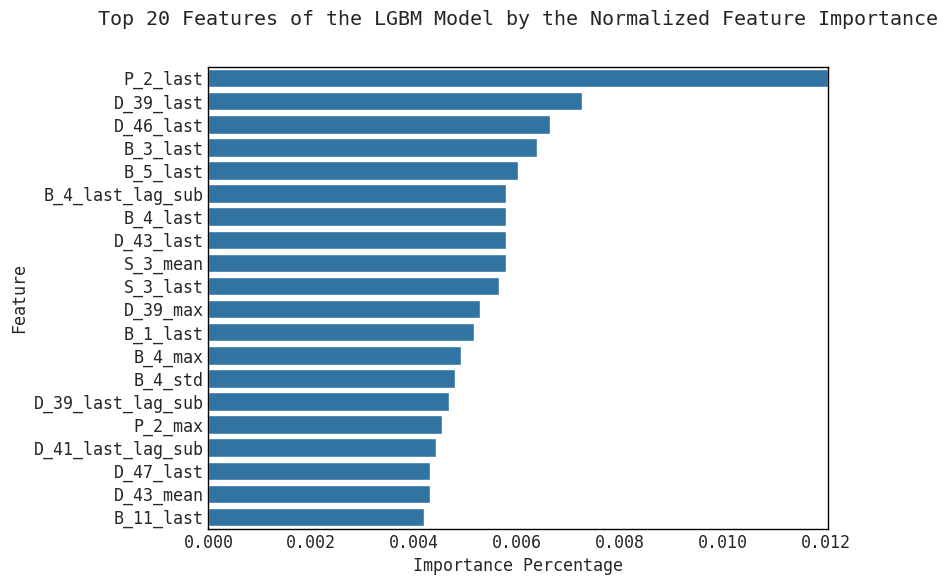

In [128]:
# get the feature importance of the LGBM model
feature_importance_lgbm = model_lgbm.feature_importances_
# get the feature names
feature_names = X_train.columns
# create a dataframe of the feature importance
df_feature_importance_lgbm = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_lgbm})
# sort the dataframe by the importance in descending order
df_feature_importance_lgbm = df_feature_importance_lgbm.sort_values(by='importance', ascending=False)
# normalize the importance
df_feature_importance_lgbm['importance'] = df_feature_importance_lgbm['importance'] / df_feature_importance_lgbm['importance'].sum()
# plot the top 20 features
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance_lgbm.head(20), legend=False)
plt.title('Top 20 Features of the LGBM Model by the Normalized Feature Importance')
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.show()

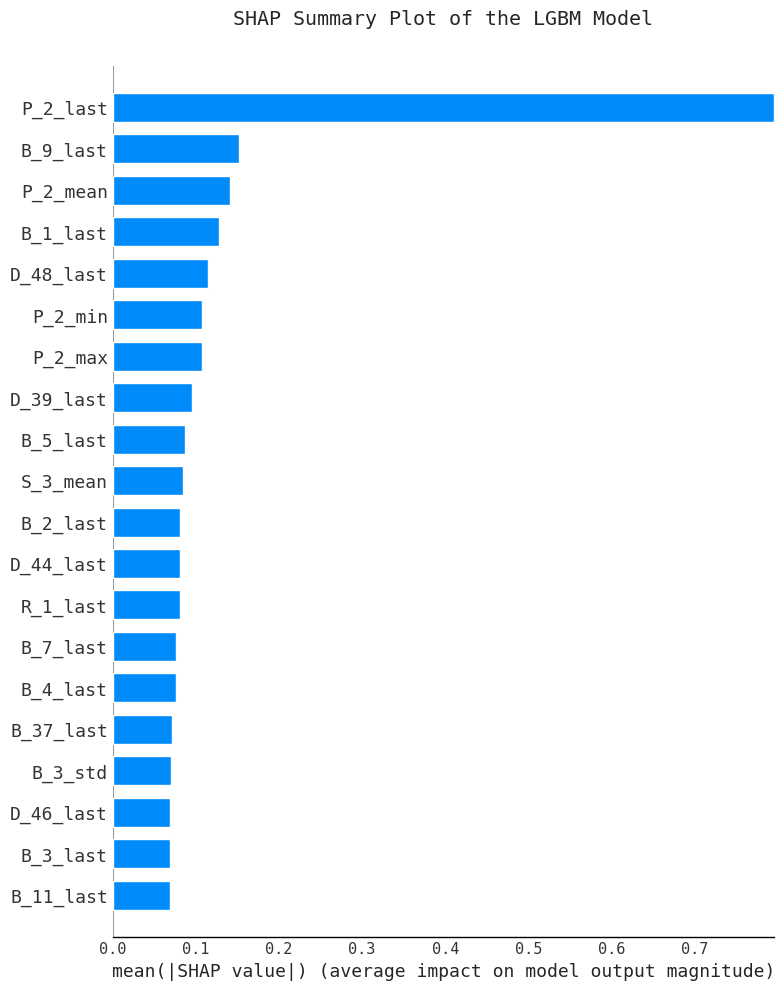

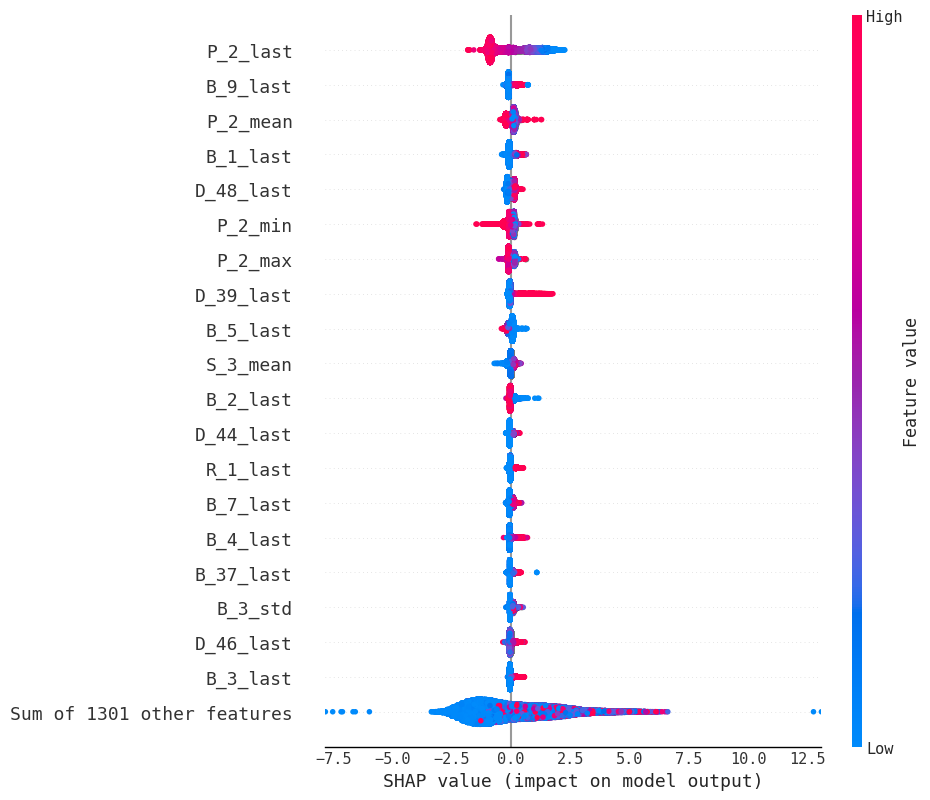

In [129]:
# Get the SHAP values for the LGBM model
explainer_lgbm = shap.TreeExplainer(model_lgbm, feature_perturbation='tree_path_dependent')
shap_values_lgbm = explainer_lgbm(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_lgbm, X_test, plot_type='bar', max_display=20, show=False)
plt.title('SHAP Summary Plot of the LGBM Model')
plt.show()
shap.plots.beeswarm(shap_values_lgbm, max_display=20)

## 5.2 Catboost

In [10]:
N_TRIALS = 5

In [11]:
# list of categorical feature names, which are the original cat_features' firsts and lasts
categorical_features = [f'{cf}_first' for cf in cat_features] + [f'{cf}_last' for cf in cat_features]

for c in categorical_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

In [ ]:
# # Set up logging to print messages to the console
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# # list of categorical feature names, which are the original cat_features' firsts and lasts
# categorical_features = [f'{cf}_first' for cf in cat_features] + [f'{cf}_last' for cf in cat_features]

# for c in categorical_features:
#     X_train[c] = X_train[c].astype('category')
#     X_test[c] = X_test[c].astype('category')

# pool_train = Pool(X_train, y_train, cat_features=categorical_features)
# pool_test = Pool(X_test, y_test, cat_features=categorical_features)

# # Define the objective function for Optuna optimization of the Catboost model
# def objective(trial):

#     param = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'depth': trial.suggest_int('depth', 8, 10),
#         'cat_features': categorical_features,
#         'eval_metric': 'AUC',
#         'has_time': False,
#         'random_seed': SEED,
#         'early_stopping_rounds': 10,
#         'iterations': 300,
#         'model_size_reg': 15,
#         'boosting_type': 'Ordered', # 'Ordered', 'Plain'
#         # 'rsm': 0.5, # random subspace method. The fraction of features to use in each boosting round
#         # 'max_ctr_complexity': 4, # The complexity of the CTR model
#         'leaf_estimation_method': 'Newton', # 'Gradient', 'Newton'
#         'leaf_estimation_iterations': 5, # The number of Newton steps in leaf value optimization
#         'verbose': 10, # print every 10 iterations
#         'task_type': 'GPU',  # Enable GPU training
#         'devices': '0'
#     }

#     model = CatBoostClassifier(**param)
#     skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
#     scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=1)
#     return scores.mean()

# # Set up the Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=N_TRIALS)

In [14]:
# Get the best parameters
best_params_catboost = {
    'learning_rate': 0.1,
    'depth': 10,
    'min_data_in_leaf': 64, 
    'colsample_bylevel': 0.75,
}
# Train the final model with the best parameters
model_catboost = CatBoostClassifier(**best_params_catboost,
                                    cat_features=categorical_features, eval_metric='AUC', random_seed=SEED,
                                     early_stopping_rounds=10, iterations=800, boosting_type='Ordered',
                                      max_ctr_complexity=4, leaf_estimation_method='Newton', leaf_estimation_iterations=5, has_time=False,
                                       verbose=50, task_type='CPU', thread_count=15)

# Split the training data into training and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Create Pool objects for training and validation sets
train_pool = Pool(data=X_train_split, label=y_train_split, cat_features=categorical_features)
valid_pool = Pool(data=X_valid_split, label=y_valid_split, cat_features=categorical_features)

# Train the model
model_catboost.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=20, use_best_model=True, plot=True)

# get the best AUC score on training set
best_score_train_catboost = model_catboost.get_best_score()

# get the best iteration on training set
best_iter_train_catboost = model_catboost.get_best_iteration()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9329456	best: 0.9329456 (0)	total: 12.7s	remaining: 2h 49m 25s
50:	test: 0.9562518	best: 0.9562518 (50)	total: 10m 36s	remaining: 2h 35m 50s
100:	test: 0.9579550	best: 0.9579550 (100)	total: 21m 9s	remaining: 2h 26m 27s
150:	test: 0.9588561	best: 0.9588561 (150)	total: 31m 42s	remaining: 2h 16m 17s
200:	test: 0.9592890	best: 0.9592890 (200)	total: 42m 26s	remaining: 2h 6m 29s
250:	test: 0.9595575	best: 0.9595605 (249)	total: 53m 14s	remaining: 1h 56m 26s
300:	test: 0.9597000	best: 0.9597000 (300)	total: 1h 4m 10s	remaining: 1h 46m 23s
350:	test: 0.9598273	best: 0.9598273 (350)	total: 1h 14m 54s	remaining: 1h 35m 49s
400:	test: 0.9598625	best: 0.9598725 (395)	total: 1h 25m 40s	remaining: 1h 25m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9598725038
bestIteration = 395

Shrink model to first 396 iterations.


NameError: name 'pool_test' is not defined

In [18]:
pool_test = Pool(X_test, y_test, cat_features=categorical_features)
# Make predictions on the test set
y_pred_catboost = model_catboost.predict_proba(pool_test)[:,1]

# Calculate the roc_auc score on the test set
roc_auc_catboost = roc_auc_score(y_test, y_pred_catboost)

# Add the Shap values to the test set
shap_catboost = model_catboost.get_feature_importance(pool_test, type='ShapValues')
df_shap_catboost = pd.DataFrame(shap_catboost[:,:-1], columns=model_catboost.feature_names_)
fea_imp_catboost = df_shap_catboost.abs().mean().sort_values(ascending=False)

# Print the best parameters and score
# logger.info(f"The CatBoost best parameters are: {best_params_catboost}")
# logger.info(f"The CatBoost best roc_auc score on the validation set is: {best_score_train_catboost['validation']['AUC']:.4f}")
# logger.info(f"The CatBoost roc_auc score on the test set is: {roc_auc_catboost:.4f}")

In [19]:
print(f"The CatBoost best parameters are: {best_params_catboost}")
print(f"The CatBoost best roc_auc score on the validation set is: {best_score_train_catboost['validation']['AUC']:.4f}")
print(f"The CatBoost roc_auc score on the test set is: {roc_auc_catboost:.4f}")

The CatBoost best parameters are: {'learning_rate': 0.1, 'depth': 10, 'min_data_in_leaf': 64, 'colsample_bylevel': 0.75}
The CatBoost best roc_auc score on the validation set is: 0.9599
The CatBoost roc_auc score on the test set is: 0.9616


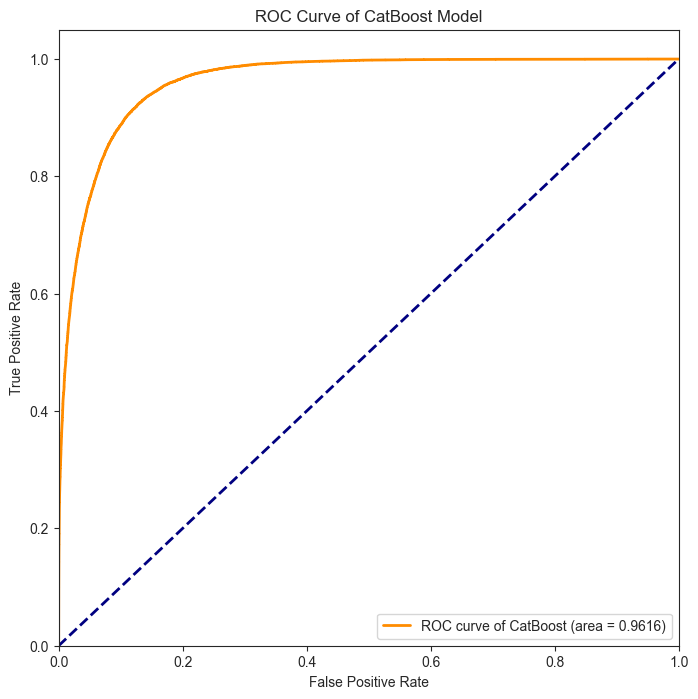

In [22]:
# print the ROC curve via catboost.plotting
catboost_roc_curve = get_roc_curve(model_catboost, pool_test)
(fpr_catboost, tpr_catboost, thresholds_catboost) = catboost_roc_curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_catboost, tpr_catboost, color='darkorange', lw=2, label='ROC curve of CatBoost (area = %0.4f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of CatBoost Model')
plt.legend(loc="lower right")
plt.show()

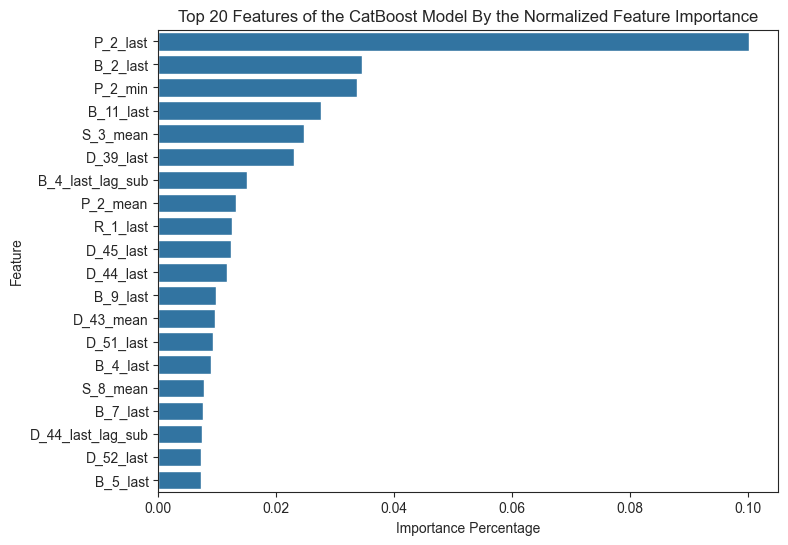

In [23]:
# get the feature importance of the catboost model
feature_importance_catboost = model_catboost.feature_importances_
# get the feature names
feature_names = X_train.columns
# create a dataframe of the feature importance
df_feature_importance_catboost = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_catboost})
# sort the dataframe by the importance in descending order
df_feature_importance_catboost = df_feature_importance_catboost.sort_values(by='importance', ascending=False)
# normalize the importance
df_feature_importance_catboost['importance'] = df_feature_importance_catboost['importance'] / df_feature_importance_catboost['importance'].sum()
# plot the top 20 features
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance_catboost.head(20), legend=False)
plt.title('Top 20 Features of the CatBoost Model By the Normalized Feature Importance')
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.show()

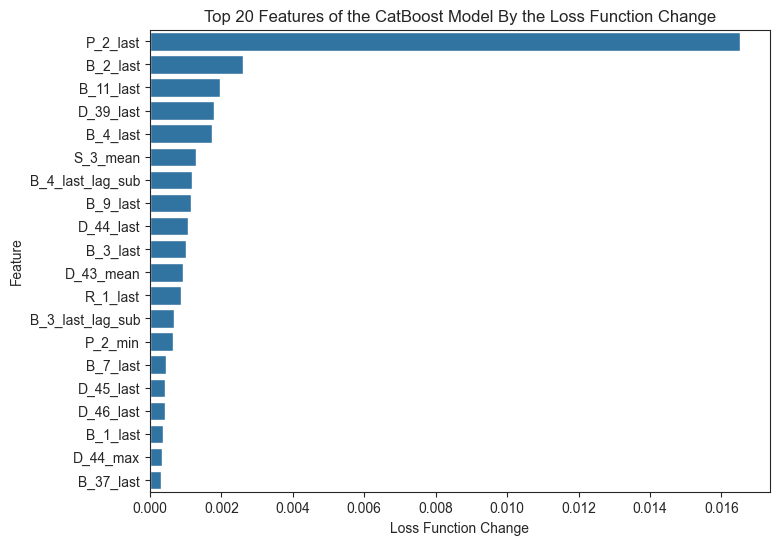

In [24]:
# get the LossFunctionChange of the catboost model
loss_function_change = model_catboost.get_feature_importance(pool_test, type='LossFunctionChange')
# get the feature names
feature_names = X_train.columns
# create a dataframe of the feature importance
df_loss_function_change = pd.DataFrame({'feature': feature_names, 'loss_function_change': loss_function_change})
# sort the dataframe by the importance in descending order
df_loss_function_change = df_loss_function_change.sort_values(by='loss_function_change', ascending=False)
# plot the top 20 features
plt.figure(figsize=(8, 6))
sns.barplot(x='loss_function_change', y='feature', data=df_loss_function_change.head(20), legend=False)
plt.title('Top 20 Features of the CatBoost Model By the Loss Function Change')
plt.xlabel('Loss Function Change')
plt.ylabel('Feature')
plt.show()

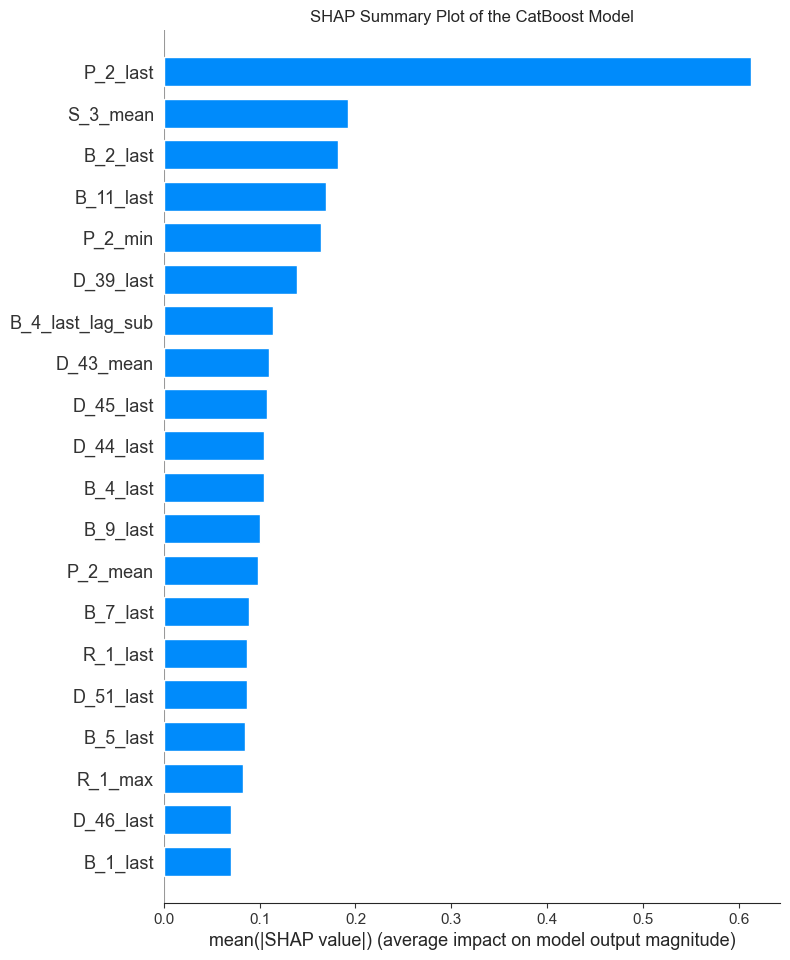

In [25]:
# Get the SHAP values for the catboost model
shap_values_catboost = model_catboost.get_feature_importance(pool_test, type='ShapValues')
# Plot the SHAP summary plot
shap.summary_plot(shap_values_catboost[:, :-1], X_test, plot_type='bar', max_display=20, show=False)
plt.title('SHAP Summary Plot of the CatBoost Model')
plt.show()

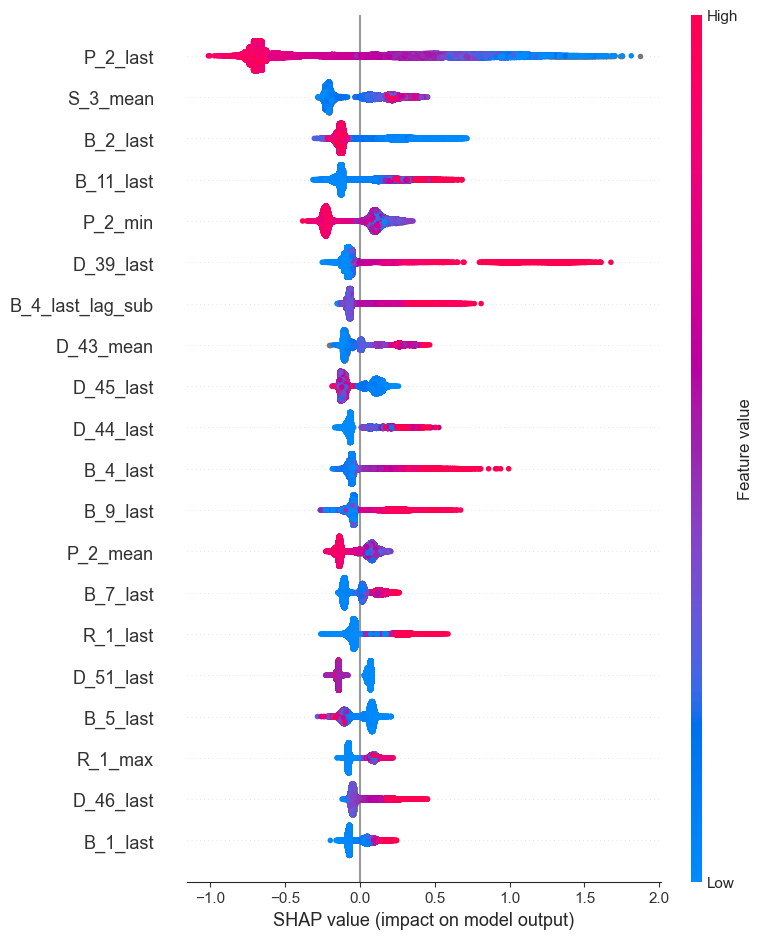

In [26]:
shap.summary_plot(shap_values_catboost[:, :-1], X_test)

In [27]:
ind = 666
shap.initjs()
shap.plots.force(shap_values_catboost[ind,-1], shap_values_catboost[ind,:-1], X_test.iloc[ind,:], feature_names=X_train.columns)